# CSE 144 Spring 2022 Assignment 1

In this assignment, the goal is to build a linear regression model to predict the song popularity based on energy, acoustics, instumentalness, liveness, dancibility, etc. We'll be using the [Song Popularity Dataset](https://www.kaggle.com/datasets/yasserh/song-popularity-dataset) dataset from Kaggle dataset.

In the first section, you'll perform standard data preprocessing using techniques we covered in class. In the second section, you'll train a simple linear regression model.

You should be able to use NumPy, Pandas, and the `train_test_split()` function from scikit-learn to complete everything in this assignment. We also imported Matplotlib for you to visualize the training and validation loss.

Remember that tuning on the test loss is prohibited.

## Rubric

The assignment is worth 57 points in total:
- Data preprocessing (12 points)
    - drop missing values (2 points)
    - drop outliers (5 points)
    - normalization (5 points)
- Dataset split (10 points)
    - test set split (5 points)
    - k-fold train and validation set split (5 points)
- Linear regression (25 points)
    - MSE_loss (3 points)
    - Gradient (5 points)
    - Specify the epoch number and learning rate (0 points)
    - Theta initialization (3 points)
    - Translate dataframe to numpy (3 points)
    - Traininig (5 points)
        - Save train and val loss (2 points)
        - Update parameters (3 points)
    - Find best parameters (3 points)
    - Evaluate on test set (3 points)
    
- Report (10 points, in a separate PDF file)
- Bonus (3 points)
    - If your test loss is below 0.025

In [ ]:
!python --version

Python 3.7.13


In [ ]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange

import random
seed = 144
random.seed(seed)
np.random.seed(seed)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18835 entries, 0 to 18834
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18714 non-null  float64
 1   song_duration_ms  18717 non-null  float64
 2   acousticness      18717 non-null  float64
 3   danceability      18712 non-null  float64
 4   energy            18697 non-null  float64
 5   instrumentalness  18700 non-null  float64
 6   key               18721 non-null  float64
 7   liveness          18695 non-null  float64
 8   loudness          18716 non-null  float64
 9   audio_mode        18715 non-null  float64
 10  speechiness       18727 non-null  float64
 11  tempo             18715 non-null  float64
 12  audio_valence     18709 non-null  float64
dtypes: float64(13)
memory usage: 2.0 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9de677bcd0>,
      dtype=object)

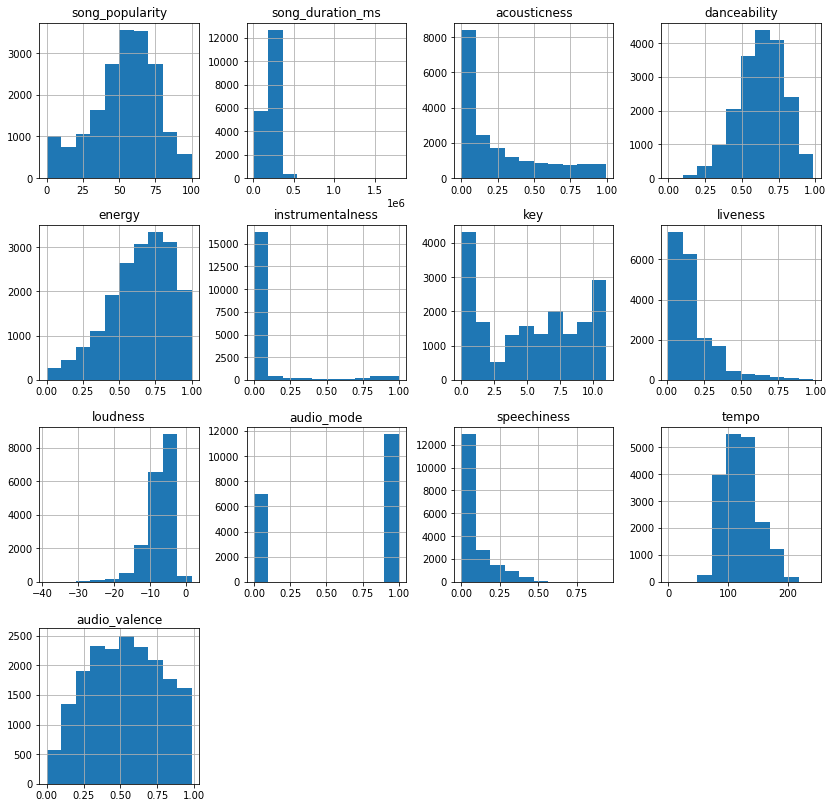

In [ ]:
# Load data
data = pd.read_csv("https://git.ucsc.edu/djrosent/ml-data/-/raw/master/song_data.csv", index_col=0).drop(["song_name"], axis = 1)
#data = pd.read_csv("./song_data.csv", index_col=0).drop(["song_name"], axis = 1)

# Visualize data 
#display(data)
data.info()
data.hist(figsize=(14,14))

### Data Cleaning
`data.info()` shows that there are some missing values in the dataset. Also, we can see from the histogram that outliers exist for some features. Moreover, the range of different features has a huge gap: most in (0,1), but some are on the order of 1e2, or even 1e5. In the following you need to perform:
1. Drop rows that contain NULL values.
2. Remove outliers for features in ['song_duration_ms', 'instrumentalness'] based on interquantile range.
3. Scale ranges of independent variables using Z-score method, and normalize the range of dependent feature ['song_popularity'] from [0,100] to [0,1]

In [ ]:
from pandas._config.config import deprecate_option
# drop rows that have NULL value
# ========== YOUR CODE STARTS HERE ==========
for index in data.index:
  if pd.isnull(data.loc[index, "song_popularity"]):
    data.drop(index, axis = 0, inplace = True)

  elif pd.isnull(data.loc[index, "song_duration_ms"]):
    data.drop(index, axis = 0, inplace = True)

  elif pd.isnull(data.loc[index, "acousticness"]):
    data.drop(index, axis = 0, inplace = True)

  elif pd.isnull(data.loc[index, "danceability"]):
    data.drop(index, axis = 0, inplace = True)

  elif pd.isnull(data.loc[index, "energy"]):
    data.drop(index, axis = 0, inplace = True)

  elif pd.isnull(data.loc[index, "instrumentalness"]):
    data.drop(index, axis = 0, inplace = True)

  elif pd.isnull(data.loc[index, "key"]):
    data.drop(index, axis = 0, inplace = True)

  elif pd.isnull(data.loc[index, "liveness"]):
    data.drop(index, axis = 0, inplace = True)

  elif pd.isnull(data.loc[index, "loudness"]):
    data.drop(index, axis = 0, inplace = True)

  elif pd.isnull(data.loc[index, "audio_mode"]):
    data.drop(index, axis = 0, inplace = True)

  elif pd.isnull(data.loc[index, "speechiness"]):
    data.drop(index, axis = 0, inplace = True)
  
  elif pd.isnull(data.loc[index, "tempo"]):
    data.drop(index, axis = 0, inplace = True)

  elif pd.isnull(data.loc[index, "audio_valence"]):
    data.drop(index, axis = 0, inplace = True)




  #data = data.reset_index(drop=True)
#display(data)
# ========== YOUR CODE ENDS HERE ============

'''
Remove outliers for features in ['song_duration_ms', 'instrumentalness'] 
based on interquantile range. Here for each feature, we first sort data in an ascending order.
Let q1 and q3 be the data that ranks 25% and 75% respectively. We then let iqr = q3 - q1, and 
compute 
                a = q1 - iqr x 1.5,
                b = q3 + iqr x 1.5,
and remove the data out of the range [a, b].
Note: this can be realized with function quantile().
'''
for feature in ['song_duration_ms', 'instrumentalness']:
    # ========== YOUR CODE STARTS HERE ==========
    #print(data["song_duration_ms"])
    Q1 = data[feature].quantile(.25)
    Q3 = data[feature].quantile(.75)
    IQR = Q3 - Q1
    a = Q1 - (IQR * 1.5)
    b = Q3 + (IQR * 1.5)
    for index in data.index:
      if (data.loc[index, feature] > b) or (data.loc[index, feature] < a):
        data.drop(index, axis = 0, inplace = True)

    # ========== YOUR CODE ENDS HERE ============
#display(data)
data = data.reset_index(drop=True)
#display(data)
'''
Scale all independent features using z-score normalization, and normalize dependent feature range to [0, 1]
Note: use different mean and std for different columns!
'''
# ========== YOUR CODE STARTS HERE ==========

for i in data.index:
  data.at[i, 'song_popularity'] = (data.at[i, 'song_popularity']) / 100
  for feature in ['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode', 'speechiness', 'tempo', 'audio_valence']:
    mean = data[feature].mean()
    std = data[feature].std()
    data.at[i, feature] = (data.at[i, feature] - mean)/std
    


# ========== YOUR CODE ENDS HERE ============

Now we visualize the data again.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12932 entries, 0 to 12931
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   12932 non-null  float64
 1   song_duration_ms  12932 non-null  float64
 2   acousticness      12932 non-null  float64
 3   danceability      12932 non-null  float64
 4   energy            12932 non-null  float64
 5   instrumentalness  12932 non-null  float64
 6   key               12932 non-null  float64
 7   liveness          12932 non-null  float64
 8   loudness          12932 non-null  float64
 9   audio_mode        12932 non-null  float64
 10  speechiness       12932 non-null  float64
 11  tempo             12932 non-null  float64
 12  audio_valence     12932 non-null  float64
dtypes: float64(13)
memory usage: 1.3 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9de2665ed0>,
      dtype=object)

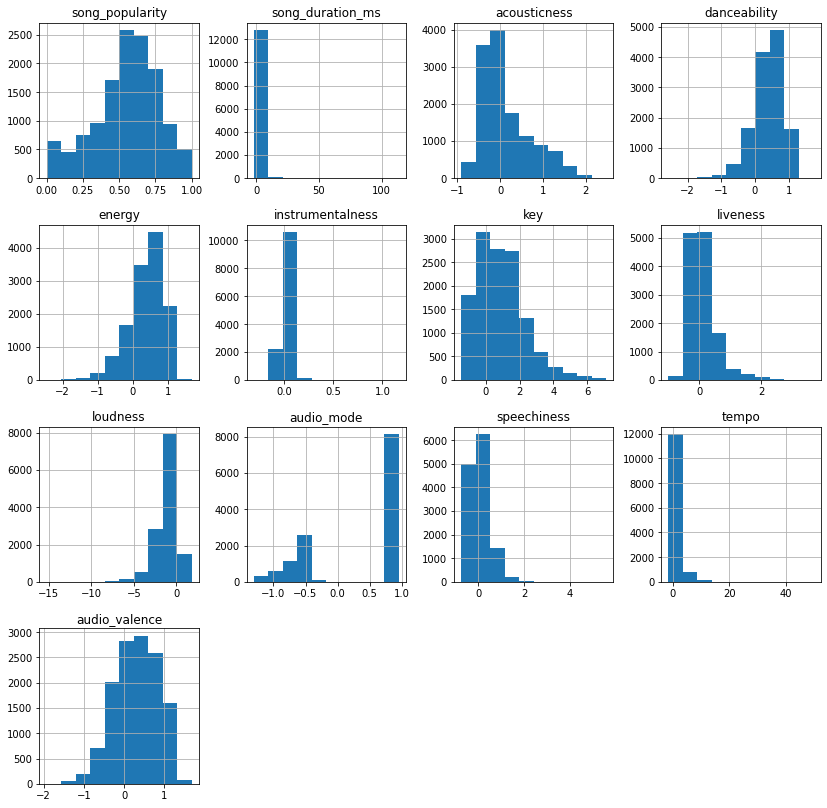

In [ ]:
data.info()
data.hist(figsize=(14,14))

## Dataset preparation
Next we will split dataset to train set, validation set and test set. First we randomly choose 30% as test set. Then we use $k$-fold validation on the remaining 70% to generate $k$ different train set and validation set pairs, where $k=5$.

In [ ]:
def test_split(data, test_size: float=0.3, seed=seed):
    '''
    Use function train_test_split() to split test set.
    '''
    # ========== YOUR CODE STARTS HERE ==========
    X = data[['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode', 'speechiness', 'tempo', 'audio_valence']] 
    Y = data['song_popularity']
    #print(Y)
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size = 0.3, random_state = seed)
    # ========== YOUR CODE ENDS HERE ============
    #print(y_train_val)
    return (X_train_val.reset_index(drop=True),
            y_train_val.reset_index(drop=True),
            X_test.reset_index(drop=True),
            y_test.reset_index(drop=True))
    

def train_val_split(X_train_val, y_train_val, k=5, seed=seed):
    '''
    Use given index sets to generate k train and validation pairs. The return value should be 
    a list whose components are tuples:
    [(X_train1, y_train1, X_val1, y_val1), ..., (X_traink, y_traink, X_valk, y_valk)]
    
    Here suppose data length is 10, the index sets could be like:
                    [[2,5], [1,6], [3,8], [9,4], [0,7]]
                    
    '''

    index_shuffle = list(X_train_val.index)
    random.shuffle(index_shuffle)
    index_split_list = [[index_shuffle[i+j] for i in range(0, len(index_shuffle), 5)  if i+j<len(index_shuffle)] for j in range(5)]

    train_val_pairs = [(None, None, None, None) for _ in range(k)]

    # ========== YOUR CODE STARTS HERE ==========

    for j in range(5):
      training = []
      testing = []
      for w in range(5):
        if w!=j:
          for item in index_split_list[w]:
            training.append(item)
        else:
          for item in index_split_list[w]:
            testing.append(item)

      train_val_pairs[j] = (X_train_val.iloc[training], y_train_val.iloc[training], X_train_val.iloc[testing], y_train_val.iloc[testing])

    # ========== YOUR CODE ENDS HERE ============    
    return train_val_pairs

X_train_val, y_train_val, X_test, y_test = test_split(data)
train_val_pairs = train_val_split(X_train_val, y_train_val)
X_test = X_test.to_numpy() # moved this here so that I can run the next cell multiple times without getting an error
y_test = y_test.to_numpy()
m = y_test.size
X_test = np.concatenate((np.ones((m, 1)), X_test), axis=1)


Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final train loss for the best model: 0.02309698433912771
Final validation loss for the best model: 0.02251915222286164
Parameters for the best model:  [ 0.56679682  0.00332247 -0.03330751  0.06284633 -0.02647704 -0.03851748
  0.00105356 -0.02040801  0.0180091  -0.0053718  -0.01395915  0.00426752
 -0.04152925]


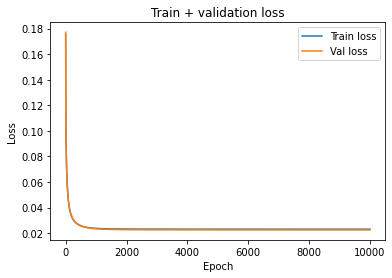

Test loss: 0.024249731190810288


In [ ]:
def MSE_loss(pred: np.ndarray, target: np.ndarray):
    # ========== YOUR CODE STARTS HERE ==========
    #transpose = np.transpose(pred)#np.subtract(pred, target))
    #print(pred.shape)
    #print(target.shape)
    m = pred.shape[0]
    sub = np.subtract(pred, target)

    #sub_squared = np.square(sub)
    #sub_squared_sum = np.sum(sub_squared)
    #return (sub_squared_sum / (2 * m))

    transpose = np.transpose(sub)
    mult = np.matmul(transpose, sub)
    cost = (1/(2 * m)) * mult
    #print(cost)
    return cost
    #mse = sub.mean()


    # ========== YOUR CODE ENDS HERE ============ 

def gradient(X: np.ndarray, y: np.ndarray, theta: np.ndarray):
    # ========== YOUR CODE STARTS HERE ==========
    #theta_transpose = np.transpose(theta)
    #x_transpose = np.transpose(X)
    #y_transpose = np.transpose(y)
    #theta_t_x_t = np.matmul(theta_transpose, x_transpose)

    #gradient = np.subtract(np.matmul(theta_t_x_t, X), np.matmul(y_transpose, X))
    #print(gradient)

    m = X.shape[0]
    X_theta = np.matmul(X, theta)
    sub = np.subtract(X_theta, y)
    step = np.matmul(sub, X)
    g = (1/m) * step
    return g

    #return gradient
    # ========== YOUR CODE ENDS HERE ============ 

# Specify epoch and learning rate
# ========== YOUR CODE STARTS HERE ==========
num_epochs = 10000
learning_rate = 0.01
# ========== YOUR CODE ENDS HERE ============ 
k = 5
train_loss_history = [[] for _ in range(k)]
val_loss_history = [[] for _ in range(k)]

theta_min = None
index_min = 0
loss_min = 10000000

for i in range(k):
    X_train, y_train, X_val, y_val = train_val_pairs[i]
    
    # Translate dataframe to numpy     
    # ========== YOUR CODE STARTS HERE ==========
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_val = X_val.to_numpy()
    y_val = y_val.to_numpy()
    
    m = y_train.size
    n = y_val.size
    X_train = np.concatenate((np.ones((m, 1)), X_train), axis=1)
    X_val = np.concatenate((np.ones((n, 1)), X_val), axis=1)

    #print(X_train)
    # ========== YOUR CODE ENDS HERE ============
    
    # Initialize theta    
    # ========== YOUR CODE STARTS HERE ==========
    theta = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    # ========== YOUR CODE ENDS HERE ============
    
    for epoch in trange(num_epochs, desc="Epoch"):
        # Compute loss, and save to train_loss_history and val_loss_history
        # ========== YOUR CODE STARTS HERE ==========

        pred = np.matmul(X_train, theta)

        loss = MSE_loss(pred, y_train)

        train_loss_history[i].append(loss)

        pred = np.matmul(X_val, theta)

        loss = MSE_loss(pred, y_val)

        val_loss_history[i].append(loss)

        # ========== YOUR CODE ENDS HERE ============
        
        # Update parameter
        # ========== YOUR CODE STARTS HERE ==========
        #print(theta)
        theta_copy = theta.copy()
        theta = np.subtract(theta_copy, learning_rate * gradient(X_train, y_train, theta_copy))
        #print(theta)
        # ========== YOUR CODE ENDS HERE ============

    
    # Inference on validation set, and find the best parameters. Save corresponding parameters and index in theta_min and  index_min
    # ========== YOUR CODE STARTS HERE ==========
    if val_loss_history[i][num_epochs - 1] < loss_min:
        loss_min = val_loss_history[i][num_epochs - 1]
        index_min = i
        theta_min = theta
    # ========== YOUR CODE ENDS HERE ============

print(f"Final train loss for the best model: {train_loss_history[index_min][-1]}")
print(f"Final validation loss for the best model: {val_loss_history[index_min][-1]}")
print("Parameters for the best model: ", theta_min)

plt.plot(np.arange(num_epochs), train_loss_history[index_min], label="Train loss")
plt.plot(np.arange(num_epochs), val_loss_history[index_min], label="Val loss")
plt.title("Train + validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Evaluate on test set
# ========== YOUR CODE STARTS HERE ==========

pred = np.matmul(X_test, theta_min)
test_loss = MSE_loss(pred, y_test)
# ========== YOUR CODE ENDS HERE ============                  
print(f"Test loss: {test_loss}")